## Getting Started

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

Borrowed from https://www.kaggle.com/c/spooky-author-identification

##### File descriptions
`train.csv` - the training set

`test.csv` - the test set

`sample_submission.csv` - a sample submission file in the correct format

##### Data fields
`id` - a unique identifier for each sentence

`text` - some text written by one of the authors

`author` - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

A reminder about playground competitions: On Kaggle, the spirit of playground competitions is to have fun and learn together. Your score on the leaderboard doesn't earn you points, but you can still make it a rewarding competition for everyone by sharing your code in Kernels and contributing to Discussions (there are prizes for both!). In short, please don't look up the answers.

### Import libraries

In [2]:
# Load libraries #

import csv
import json

import numpy
import pandas
from time import time

from matplotlib import pyplot
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

### Load datasets

In [3]:
# Load all data #

authored_contents = pandas.read_csv("./author detection datasets/train.csv")

unauthored_contents = pandas.read_csv("./author detection datasets/test.csv")

In [4]:
authored_contents.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
unauthored_contents.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [6]:
authored_contents.shape

(19579, 3)

### Data Exploration

The objective here is to scan through the test documents and identify the potential author of each document.

`text` represents the documents and is our feature.

`author` is our target variable.

In [7]:
authored_contents.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id07303,I escaped from them to the room where lay the ...,EAP
freq,1,1,7900


In [8]:
training_records = len(authored_contents)

author_eap, author_mws, author_hpl = authored_contents.author.value_counts()

print("Total number of authored contents: ", training_records)
print("Total number of authored contents by EAP: ", author_eap)
print("Total number of authored contents by MWS: ", author_mws)
print("Total number of authored contents by HPL: ", author_hpl)

('Total number of authored contents: ', 19579)
('Total number of authored contents by EAP: ', 7900)
('Total number of authored contents by MWS: ', 6044)
('Total number of authored contents by HPL: ', 5635)


Below, we shall study the text length in the training dataset.

In [9]:
# grab text length of each contents

authored_contents['text_length'] = authored_contents['text'].str.len()

In [10]:
authored_contents.head()

,id,text,author,text_length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


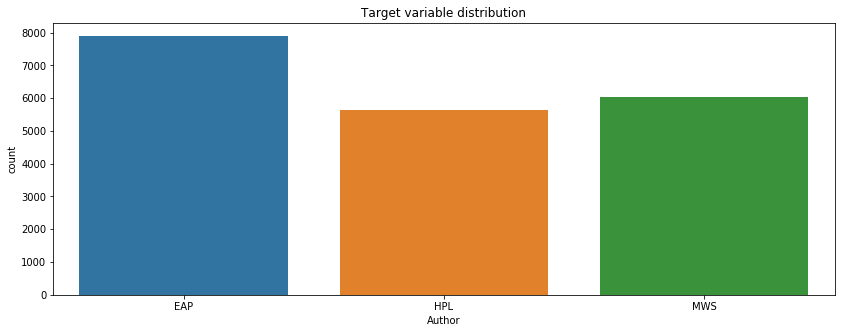

In [12]:
pyplot.figure(figsize=(14,5))
sns.countplot(authored_contents['author'],)
pyplot.xlabel('Author')
pyplot.title('Target variable distribution')
pyplot.show()

Now, grouping all the documents by each author to better understand the count.

In [13]:
authored_contents.groupby('author').size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

Below, we shall study the text length in the testing dataset.

In [17]:
# examine the same in test data

testing_records = len(unauthored_contents)

unauthored_contents['text_length'] = unauthored_contents['text'].str.len()

In [18]:
unauthored_contents.head()

,id,text,text_length
0,id02310,"Still, as I urged our leaving Ireland with suc...",110
1,id24541,"If a fire wanted fanning, it could readily be ...",330
2,id00134,And when they had broken down the frail door t...,189
3,id27757,While I was thinking how I should possibly man...,223
4,id04081,I am not sure to what limit his knowledge may ...,53


### Data Preprocessing

Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. 

As with the non-numeric features, we need to convert the non-numeric target label, `author` to numerical values for the learning algorithm to work. Since there are only three possible categories for this label ("EAP", "HPL" and "MWS"), we can avoid using one-hot encoding and simply encode these two categories as 0, 1 and 2 respectively.

In code cell below, you will need to implement the following:

- Convert the target label 'income_raw' to numerical entries. Set records with "EAP" to 0, records with "HPL" to 1 and records with "MWS" to 2 and storing it in `numerical_author` column.
- Downcase, stem and remove punctations from the `text` ad storing it in `scrubbed_text` column.

In [20]:
# binarize author in the training dataset

authored_contents['numerical_author'] = authored_contents.author.map({ 'EAP': 0, 'HPL': 1, 'MWS': 2 })

In [21]:
authored_contents.head()

,id,text,author,text_length,numerical_author
0,id26305,"This process, however, afforded me no means of...",EAP,231,0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,1


In [22]:
all_stopwords = stopwords.words('english')
ps = PorterStemmer()

def scrub_text(data_frame):
    sentences = []
    for i in data_frame.values:
        sentence = unicode(i[1], 'utf-8')

        # remove all punctuations
        sentence = sentence.translate(string.punctuation)

        # break sentence into words
        array_of_words = word_tokenize(sentence)

        # removes all English stopwords
        array_of_words = [word for word in array_of_words if word.lower() not in all_stopwords]

        # singularise words in the array_of_words
        array_of_words = [ps.stem(word) for word in array_of_words]
        cleaned_sentence = ' '.join(array_of_words)

        sentences.append(cleaned_sentence)

    return sentences

In [25]:
# Run the #scrub_text over the text in the training and testing datasets.

training_cleaned_texts = scrub_text(authored_contents)
testing_cleaned_texts = scrub_text(unauthored_contents)

In [26]:
authored_contents['scrubbed_text'] = training_cleaned_texts

unauthored_contents['scrubbed_text'] = testing_cleaned_texts

In [40]:
# Define labels and features set

X = authored_contents['scrubbed_text']
Y = authored_contents['numerical_author']

### Shuffle and split data

We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [28]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size = 0.2,
                                                    random_state = 0)

/Users/kavitakanojiya/anaconda2/envs/udacity/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
# Show the results of the split

# Features
print("Training set has " + str(X_train.shape[0]) + " features.")
print("Testing set has " + str(X_test.shape[0]) + " features.")

# Labels
print("Training set has " + str(Y_train.shape[0]) + " labels.")
print("Testing set has " + str(Y_test.shape[0]) + " labels.")

print("\nPrinting labels set...")
print(Y_train.value_counts())

print(Y_test.value_counts())

Training set has 15663 features.
Testing set has 3916 features.
Training set has 15663 labels.
Testing set has 3916 labels.

Printing labels set...
0    6300
2    4830
1    4533
Name: numerical_author, dtype: int64
0    1600
2    1214
1    1102
Name: numerical_author, dtype: int64


###### Another cross validation:

We will now cross-validate our training set using `sklearn.model_selection.StratifiedShuffleSplit` approach

This as mentioned in the training videos, this will divide our training set into N folds.
We will iterate over each fold acting as testing data at a single point of time and rest of them will act as training sets.

We will tweak certain parameters to learn the dataset pattern.

In [41]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X,
                                                        Y,
                                                        stratify = Y,
                                                        test_size = 0.2,
                                                        random_state = 42)

In [42]:
# Show the results of the split

# Features
print("Training set has " + str(X2_train.shape[0]) + " features.")
print("Testing set has " + str(X2_test.shape[0]) + " features.")

# Labels
print("\nTraining set has " + str(Y2_train.shape[0]) + " labels.")
print("Testing set has " + str(Y2_test.shape[0]) + " labels.")

print("\nPrinting labels set...")
print(Y_train.value_counts())

print(Y_test.value_counts())

Training set has 15663 features.
Testing set has 3916 features.

Training set has 15663 labels.
Testing set has 3916 labels.

Printing labels set...
0    6300
2    4830
1    4533
Name: numerical_author, dtype: int64
0    1600
2    1214
1    1102
Name: numerical_author, dtype: int64


### Create features out of the texts

We shall now grab the words in a document and tokenize them and build vocabulary out of them.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

training_vectorizer = vectorizer.transform(X2_train)

### Evaluating Model Performance

The following are some of the supervised learning models that will be used to evaluate the performance of the model on this problem and the dataset.

- Multinomial Naive Bayes
- Logistic Regression
- XGBoost from the ensemble methods
- SVM
- Stochastic Gradient Descent Classifier (SGDC)

In [38]:
# Include libraries to evaluate performances on the attached dataset

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

##### Multinomial Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB

kfold = KFold(n_splits = 10, random_state = 7)

model = MultinomialNB()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.823660287491
Training time: 0.0937268733978


##### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

kfold = KFold(n_splits = 10, random_state = 7)

model = LogisticRegression()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.805338637495
Training time: 2.65445709229


##### SVM

In [41]:
from sklearn.svm import SVC

kfold = KFold(n_splits = 10, random_state = 7)

model = SVC()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.403498032945
Training time: 299.708959103


##### Stochastic Gradient Descent Classifier

In [40]:
from sklearn.linear_model import SGDClassifier

kfold = KFold(n_splits = 10, random_state = 7)

model = SGDClassifier()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.794548604234
Training time: 0.322958230972


##### XGBoost

In [45]:
from xgboost import XGBClassifier

model = XGBClassifier()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.612143091753
Training time: 52.5109481812


#### Conclusion:

         Algorithm            Mean accuracy    Training time            O/P
    Multinomial Naive Bayes      0.823            0.093        .82 accuracy with the least amount of training time
     Logistic Regression         0.805            2.654        .80 accuracy with some amount of training time
            SGDC                 0.794            0.322        .79 accuracy with the least of training time
          XGBoost                0.612            52.510       .61 accuracy with unacceptable training time
            SVM                  0.403            299.708      least accuracy with highest amount of training time

Keeping accuracy with training time, I will move ahead with Multinomial Naive Bayes.

### Review CountVectorizer

In [44]:
print(len(vectorizer.get_feature_names()))

14423


In [45]:
# run vectorizer for X2_test

testing_vectorizer = vectorizer.transform(X2_test)

In [46]:
training_vectorizer

<15663x14423 sparse matrix of type '<type 'numpy.int64'>'
	with 197739 stored elements in Compressed Sparse Row format>

In [47]:
testing_vectorizer

<3916x14423 sparse matrix of type '<type 'numpy.int64'>'
	with 49899 stored elements in Compressed Sparse Row format>

As per the above transformation, training_vectorizer is our feature set.

### Parameter tuning

Fine tune the chosen model. Use grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this.

In the code cell below, we shall implement the following:

- Import sklearn.grid_search.GridSearchCV and sklearn.metrics.make_scorer.
- Initialize the classifier you've chosen and store it in `model`.
- Create a dictionary of parameters you wish to tune for the chosen model.
  Example: parameters = {'parameter' : [list of values]}.
- Use make_scorer to create an fbeta_score scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier clf using the 'scorer', and store it in grid_obj.
- Fit the grid search object to the training data (`training_vectorizer, Y2_train`), and store it in grid_fit.

In [50]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.naive_bayes import MultinomialNB

In [51]:
model = MultinomialNB()

parameters = { 'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0] }

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(model, parameters)

grid_fit = grid_obj.fit(training_vectorizer, Y2_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

grid_fit.best_params_

{'alpha': 0.1}

### Run on model

In [57]:
mnb = MultinomialNB(alpha = 0.1)

In [58]:
mnb.fit(training_vectorizer, Y2_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [59]:
Y_train_prediction = mnb.predict(training_vectorizer)

In [60]:
Y_test_prediction = mnb.predict(testing_vectorizer)

In [61]:
# calculate score for predicted data against testing data
from sklearn import metrics

# compare predicted resultset with the test set
metrics.accuracy_score(Y2_test, Y_test_prediction)

0.83324821246169556

In [62]:
# calculate score for predicted data against training data

metrics.accuracy_score(Y2_train, Y_train_prediction)

0.90934048394305045

In [63]:
# Calculate confusion matrix

metrics.confusion_matrix(Y2_test, Y_test_prediction)

array([[1295,  111,  174],
       [  95,  951,   81],
       [ 119,   73, 1017]])

In [64]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = mnb.predict_proba(testing_vectorizer)
y_pred_prob[:10]

array([[  9.99786719e-01,   2.13280088e-04,   4.89994895e-10],
       [  8.66947595e-01,   9.95241185e-02,   3.35282869e-02],
       [  8.49678290e-01,   1.45988380e-01,   4.33333032e-03],
       [  9.99898759e-01,   5.47849938e-05,   4.64555177e-05],
       [  5.00125060e-01,   7.70779393e-03,   4.92167146e-01],
       [  6.01738666e-12,   9.54460415e-12,   1.00000000e+00],
       [  1.10104174e-07,   9.91861523e-01,   8.13836718e-03],
       [  5.96328213e-09,   1.26892029e-13,   9.99999994e-01],
       [  1.81717396e-05,   9.99885477e-01,   9.63511503e-05],
       [  3.35899059e-01,   6.00869334e-01,   6.32316074e-02]])

In [65]:
print(classification_report(Y2_train, Y_train_prediction, target_names=['EAP', 'HPL', 'MWS']))

             precision    recall  f1-score   support

        EAP       0.92      0.89      0.91      6320
        HPL       0.92      0.92      0.92      4508
        MWS       0.88      0.92      0.90      4835

avg / total       0.91      0.91      0.91     15663



In [83]:
fpr, tpr, thresholds = metrics.roc_curve(Y2_train, Y_train_prediction, pos_label = 1)

print("Multinomial naive bayes AUC: {0}").format(metrics.auc(fpr, tpr))

Multinomial naive bayes AUC: 0.535750677017


### Running the prediction over `test.csv`

In [66]:
# vectorise the unauthored_contents

unpredicted_texts = unauthored_contents['text']

unpredicted_texts_vectorizer = vectorizer.transform(unpredicted_texts)

In [67]:
unpredicted_texts_vectorizer

<8392x14423 sparse matrix of type '<type 'numpy.int64'>'
	with 99981 stored elements in Compressed Sparse Row format>

In [68]:
unpredicted_texts_prediction = mnb.predict(unpredicted_texts_vectorizer)

In [69]:
# calculate predicted probabilities for X_test_dtm
predicted_prob = mnb.predict_proba(unpredicted_texts_vectorizer)
predicted_prob[:10]

array([[  2.20145424e-01,   1.65946539e-05,   7.79837982e-01],
       [  1.00000000e+00,   5.41858656e-16,   2.72654739e-15],
       [  9.99999954e-01,   1.06708018e-11,   4.59154695e-08],
       [  9.99999686e-01,   7.66512661e-11,   3.14064718e-07],
       [  9.99994603e-01,   3.73458037e-06,   1.66197799e-06],
       [  9.99991508e-01,   8.33126697e-11,   8.49152919e-06],
       [  9.99995839e-01,   2.71821471e-06,   1.44304027e-06],
       [  9.99987890e-01,   2.16332280e-08,   1.20879117e-05],
       [  1.00000000e+00,   6.23110653e-18,   3.44319780e-10],
       [  9.59449853e-01,   1.92011226e-04,   4.03581360e-02]])

In [70]:
unpredicted_texts_prediction

array([2, 0, 0, ..., 0, 0, 0])

In [71]:
len(unauthored_contents)

8392

In [72]:
numerical_authors = pandas.DataFrame(unpredicted_texts_prediction, columns=['num_author'])

predicted_unauthored_contents = pandas.concat([unauthored_contents, numerical_authors], axis=1)

In [73]:
predicted_unauthored_contents['author'] = predicted_unauthored_contents.num_author.map({ 0: 'EAP', 1: 'HPL', 2: 'MWS' })

In [81]:
predicted_unauthored_contents.groupby('author').size()

author
EAP    7534
HPL     282
MWS     576
dtype: int64

In [84]:
predicted_unauthored_contents.head()

,id,text,text_length,scrubbed_text,num_author,author
0,id02310,"Still, as I urged our leaving Ireland with suc...",110,"still , urg leav ireland inquietud impati , fa...",2,MWS
1,id24541,"If a fire wanted fanning, it could readily be ...",330,"fire want fan , could readili fan newspap , go...",0,EAP
2,id00134,And when they had broken down the frail door t...,189,broken frail door found : two cleanli pick hum...,0,EAP
3,id27757,While I was thinking how I should possibly man...,223,"think possibl manag without , one actual tumbl...",0,EAP
4,id04081,I am not sure to what limit his knowledge may ...,53,sure limit knowledg may extend .,0,EAP


### Write modified train.csv and test.csv to CSV files

In [78]:
# authored_contents.to_csv('./author detection datasets/authored_contents.csv')

In [77]:
# predicted_unauthored_contents.to_csv('./author detection datasets/predicted_unauthored_contents.csv')